# **Natural Language Processing with Python**
by [CSpanias](https://cspanias.github.io/aboutme/) - 02/2022

Content based on the [NLTK book](https://www.nltk.org/book/). <br>

You can find Chapter 6 [here](https://www.nltk.org/book/ch06.html).

# CONTENT

1. Language Processing and Python
2. Accessing Text Corpora and Lexical Resources
3. Processing Raw Text
4. Writing Structured Programs
5. Categorizing and Tagging Words
6. [Learning to Classify Text](#textclass)
    1. [Supervised Classification](#supervisedclass)
        1. [Gender Identification](#gender)
        1. [Choosing the Right Features](#features)
        1. [Document Classification](#docclass)
        1. [POS Tagging](#postag)
        1. [Exploiting Context](#context)
        1. [Sequence Classification](#seqclass)
        1. [Other Methods for Sequence Classification](#other)
    2. [Futher Examples of Supervised Classification](#examples)
        1. [Sentence Segmentation](#sentsegmentation)
        1. [Identifying Dialogue Act Types](#dialogueact)
        1. [Recognizing Textual Entailment](#textualentailment)
        1. [Scaling Up to Large Datasets](#bigdata)

<a name="textclass"></a>
# 6. Learning to Classify Text

__Detecting patterns__ is a central part of NLP. 

Words ending in `-ed` tend to be __past tense verbs__. Frequent use of `will` is indicative of __news text__. 

These observable patterns — __word structure__ and __word frequency__ — __happen to correlate__ with particular aspects of meaning, such as __tense__ and __topic__. 

But how did we know where to start looking, which aspects of form to associate with which aspects of meaning?

The goal of this chapter is to answer the following questions:

1. How can we identify particular features of language data that are salient for classifying it?

1. How can we construct models of language that can be used to perform language processing tasks automatically?

1. What can we learn about language from these models?


Along the way we will study some important __machine learning techniques__, including decision trees, naive Bayes' classifiers, and maximum entropy classifiers.

<a name="supervisedclass"></a>
# 6.1 Supervised Classification

Classification is __the task of choosing the correct class label for a given input__. 

In basic classification tasks, each input is considered in isolation from all other inputs, and the __set of labels is defined in advance__. 

Some examples of classification tasks are:

* Deciding whether an email is spam or not.

* Deciding what the topic of a news article is, from a fixed list of topic areas such as "sports," "technology," and "politics."

* Deciding whether a given occurrence of the word `bank` is used to refer to a river bank, a financial institution, the act of tilting to the side, or the act of depositing something in a financial institution.

The basic classification task has a number of interesting variants. For example, in __multi-class classification__, each instance may be assigned multiple labels; in __open-class classification__, the set of labels is not defined in advance; and in __sequence classification__, a list of inputs are jointly classified.

A classifier is called supervised if it is built based on training corpora containing the correct label for each input. The framework used by supervised classification is shown in the figure below.

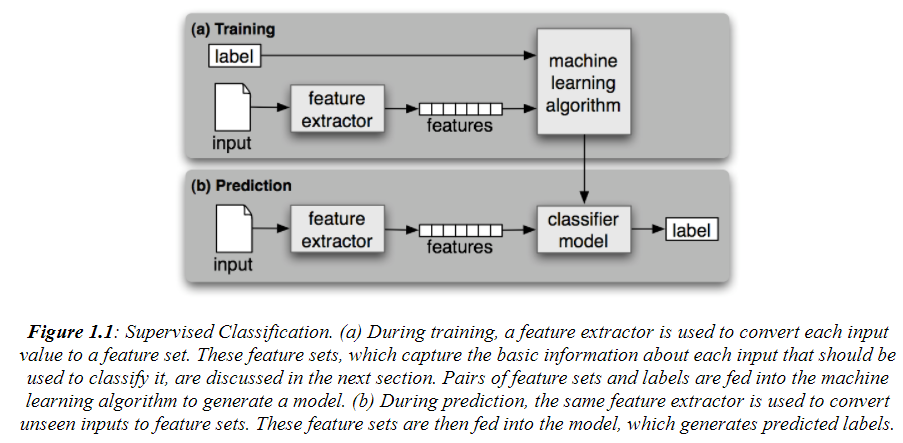

<a name="gender"></a>
## 6.1.1 Gender Identification

Male and female names have some __distinctive characteristics__. 

Names ending in `a`, `e` and `i` are likely to be __female__, while names ending in `k`, `o`, `r`, `s` and `t` are likely to be __male__. 

Let's build a classifier to model these differences more precisely.

The first step in creating a classifier is __deciding what features of the input are relevant__, and __how to encode those features__. 

For this example, we'll start by just looking at the final letter of a given name. The following feature extractor function builds a dictionary containing relevant information about a given name.

In [1]:
def gender_features(word):
    return {'last_letter': word[-1]}

gender_features('Shrek')

{'last_letter': 'k'}

The returned dictionary, known as a __feature set__, maps from feature names to their values. 

__Feature names are _case-sensitive strings__ that typically provide a short human-readable description of the feature, as in the example `'last_letter'`. 

__Feature values are values with simple types__, such as booleans, numbers, and strings.

Most classification methods require that __features be encoded using simple value types__, such as booleans, numbers, and strings. 

But note that __just because a feature has a simple type, this does not necessarily mean that the feature's value is simple to express or compute__. 

Indeed, it is even possible to use very complex and informative values, such as the output of a second supervised classifier, as features.

Now that we've defined a feature extractor, we need to __prepare a list of examples and corresponding class labels__.

In [2]:
from nltk.corpus import names
import random

labeled_names = ([(name, 'male') for name in names.words('male.txt')] + 
                 [(name, 'female') for name in names.words('female.txt')])
                 
random.shuffle(labeled_names)

Next, we __use the feature extractor to process the names data__, and divide the resulting list of feature sets into a __training set and a test set__. 

The training set is used to __train a new "naive Bayes" classifier__.

In [3]:
from nltk import NaiveBayesClassifier

features_sets = [(gender_features(n), gender) for (n, gender) in labeled_names]

train_set, test_set = features_sets[500:], features_sets[:500]

classifier = NaiveBayesClassifier.train(train_set)

Now, let's __test it out on some names that did not appear in its training data__.

In [4]:
classifier.classify(gender_features('Neo'))

'male'

In [5]:
classifier.classify(gender_features('Trinity'))

'female'

We can __systematically evaluate the classifier on a much larger quantity of unseen data__.

In [6]:
from nltk.classify import accuracy

accuracy(classifier, test_set)

0.748

Finally, we can examine the classifier to determine __which features it found most effective for distinguishing the names' genders__.

In [7]:
classifier.show_most_informative_features(5)

Most Informative Features
             last_letter = 'a'            female : male   =     35.7 : 1.0
             last_letter = 'k'              male : female =     31.2 : 1.0
             last_letter = 'f'              male : female =     16.6 : 1.0
             last_letter = 'p'              male : female =     12.5 : 1.0
             last_letter = 'v'              male : female =     10.5 : 1.0


This listing shows that the names in the training set that end in `"a"` are __female 33 times more often than they are male__, but names that end in `"k"` are __male 32 times more often than they are female__. 

These ratios are known as __likelihood ratios__, and can be useful for comparing different feature-outcome relationships.

__Your Turn__: Modify the `gender_features()` function to provide the classifier with features encoding:
1. the length of the name
1. its first letter
1. and any other features that seem like they might be informative. 

Retrain the classifier with these new features, and test its accuracy.

In [8]:
from nltk import NaiveBayesClassifier
from nltk.classify import accuracy

# modify function
def gender_features(word):
    # extract last letter
    return {'last_letter': word[-1],
            # extract first letter
            'first_letter': word[0],
            # extract word length
            'name_length': len(word),
           }

# test function
print(gender_features('Shrek'), "\n")

# create feature sets
features_sets = [(gender_features(n), gender) 
                 for (n, gender) in labeled_names]

# split data
train_set, test_set = features_sets[500:], features_sets[:500]

# train model
classifier = NaiveBayesClassifier.train(train_set)

# evaluate model's accuracy
accuracy(classifier, test_set)

{'last_letter': 'k', 'first_letter': 'S', 'name_length': 5} 



0.752

When working with large corpora, constructing a single list that contains the features of every instance can use up a __large amount of memory__. 

In these cases, use the function `nltk.classify.apply_features`, which returns an object that acts like a list but does not store all the feature sets in memory.

In [9]:
from nltk.classify import apply_features

train_set = apply_features(gender_features, labeled_names[500:])
test_set = apply_features(gender_features, labeled_names[:500])

print(type(train_set))

<class 'nltk.collections.LazyMap'>


<a name="features"></a>
## 6.1.2 Choosing the Right Features

__Selecting relevant features and deciding how to encode them for a learning method can have an enormous impact__ on the learning method's ability to extract a good model. 

Much of the interesting work in building a classifier is deciding what features might be relevant, and how we can represent them. Although it's often possible to get decent performance by using a fairly simple and obvious set of features, there are usually significant gains to be had by using carefully constructed features based on a __thorough understanding of the task at hand__.

Typically, feature extractors are built through a process of __trial-and-error__, guided by __intuitions__ about what information is relevant to the problem. 

It's common to start with a __"kitchen sink" approach__, including all the features that you can think of, and then checking to see which features actually are helpful.

In [10]:
def gender_features2(name):
    
    features = {}
    # extract & lower-case first letter
    features['first_letter'] = name[0].lower()
    # extract & lower-case last letter
    features['last_letter'] = name[-1].lower()
    # for every letter in the eng alphabet
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        
        features['count({})'.format(letter)] = name.lower().count(letter)
        features['has({})'.format(letter)] = (letter in name.lower())
    return features

# test feature extractor
print(gender_features2('John'))

{'first_letter': 'j', 'last_letter': 'n', 'count(a)': 0, 'has(a)': False, 'count(b)': 0, 'has(b)': False, 'count(c)': 0, 'has(c)': False, 'count(d)': 0, 'has(d)': False, 'count(e)': 0, 'has(e)': False, 'count(f)': 0, 'has(f)': False, 'count(g)': 0, 'has(g)': False, 'count(h)': 1, 'has(h)': True, 'count(i)': 0, 'has(i)': False, 'count(j)': 1, 'has(j)': True, 'count(k)': 0, 'has(k)': False, 'count(l)': 0, 'has(l)': False, 'count(m)': 0, 'has(m)': False, 'count(n)': 1, 'has(n)': True, 'count(o)': 1, 'has(o)': True, 'count(p)': 0, 'has(p)': False, 'count(q)': 0, 'has(q)': False, 'count(r)': 0, 'has(r)': False, 'count(s)': 0, 'has(s)': False, 'count(t)': 0, 'has(t)': False, 'count(u)': 0, 'has(u)': False, 'count(v)': 0, 'has(v)': False, 'count(w)': 0, 'has(w)': False, 'count(x)': 0, 'has(x)': False, 'count(y)': 0, 'has(y)': False, 'count(z)': 0, 'has(z)': False}


The feature sets returned by this feature extractor contain a large number of specific features, leading to overfitting for the relatively small Names Corpus.

However, there are usually __limits to the number of features that you should use with a given learning algorithm__ — if you provide too many features, then the algorithm will have a higher chance of relying on idiosyncrasies of your training data that don't generalize well to new examples. 

This problem is known as __overfitting__, and can be especially problematic when working with small training sets. 

For example, if we train a naive Bayes classifier using the feature extractor we just built, it will overfit the relatively small training set, resulting in a system whose accuracy is about 1% lower than the accuracy of a classifier that only pays attention to the final letter of each name.

In [11]:
# extract features
feature_sets = [(gender_features2(n), gender) 
                for (n, gender) in labeled_names]
# split dataset
train_set, test_set = feature_sets[500:], feature_sets[:500]
# instantiate & train classifier with train set
classifier = NaiveBayesClassifier.train(train_set)
# evaluate classifier on test set
print(accuracy(classifier, test_set))

0.764


Once an initial set of features has been chosen, a very productive method for refining the feature set is __error analysis__. 

First, we select a __development set__, containing the corpus data for creating the model. 

This development set is then subdivided into the __training set__ and the __dev-test__ set.

In [12]:
train_names = labeled_names[1500:]
devtest_names = labeled_names[500:1500]
test_names = labeled_names[:500]

The __training set is used to train the model__, and the __dev-test set is used to perform error analysis__. 

The __test set serves in our final evaluation of the system__.

For reasons discussed below, it is important that we employ a separate dev-test set for error analysis, rather than just using the test set.

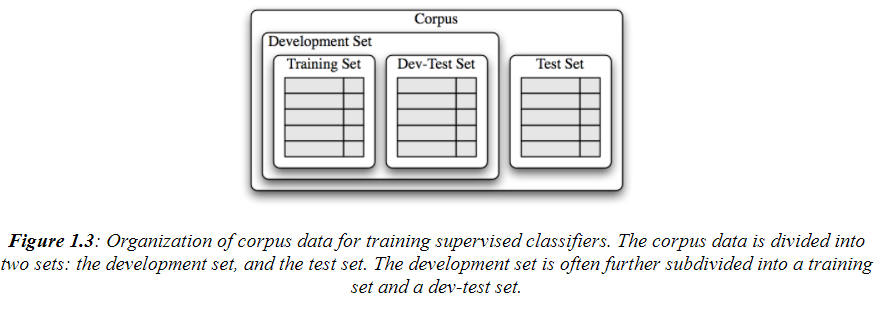

Having divided the corpus into appropriate datasets, we train a model using the training set, and then run it on the dev-test set.

In [13]:
train_set = [(gender_features(n), gender)
            for (n, gender) in train_names]

devtest_set = [(gender_features(n), gender) 
              for (n, gender) in devtest_names]

test_set = [(gender_features(n), gender)
           for (n, gender) in test_names]

# instantiate & train classifier with train set
classifier = NaiveBayesClassifier.train(train_set)
# evaluate classifier on test set
print(accuracy(classifier, devtest_set))

0.773


Using the dev-test set, we can generate __a list of the errors__ that the classifier makes when predicting name genders.

In [14]:
errors = []

for (name, tag) in devtest_names:
    guess = classifier.classify(gender_features(name))
    if guess != tag:
        errors.append( (tag, guess, name) )

We can then __examine individual error cases__ where the model predicted the wrong label, and try to determine what additional pieces of information would allow it to make the right decision (or which existing pieces of information are tricking it into making the wrong decision).

The feature set can then be adjusted accordingly. The names classifier that we have built generates about __100 errors on the dev-test corpus__.

In [15]:
for (tag, guess, name) in sorted(errors):
    print('correct={:<8} guess={:<8s} name={:<30}'
         .format(tag, guess,name))

correct=female   guess=male     name=Addis                         
correct=female   guess=male     name=Alexis                        
correct=female   guess=male     name=Alison                        
correct=female   guess=male     name=Alyson                        
correct=female   guess=male     name=Amber                         
correct=female   guess=male     name=Austin                        
correct=female   guess=male     name=Barb                          
correct=female   guess=male     name=Beryl                         
correct=female   guess=male     name=Beulah                        
correct=female   guess=male     name=Brandy                        
correct=female   guess=male     name=Bren                          
correct=female   guess=male     name=Brenn                         
correct=female   guess=male     name=Brit                          
correct=female   guess=male     name=Britt                         
correct=female   guess=male     name=Clo        

Looking through this list of errors __makes it clear that some suffixes that are more than one letter can be indicative of name genders__. 

For example, names ending in `yn` appear to be predominantly female, despite the fact that names ending in `n` tend to be male; and names ending in `ch` are usually male, even though names that end in `h` tend to be female. 

We therefore adjust our feature extractor to include features for two-letter suffixes.

In [16]:
def gender_features(word):
    return {'suffix1': word[-1:],
           'suffix2': word[-2]}

Rebuilding the classifier with the new feature extractor, we see that the performance on the dev-test dataset __improves by almost 2 percentage points__ (from 76.5% to 78.2%).

In [17]:
train_set = [(gender_features(n), gender)
            for (n, gender) in train_names]

devtest_set = [(gender_features(n), gender) 
              for (n, gender) in devtest_names]

# instantiate & train classifier with train set
classifier = NaiveBayesClassifier.train(train_set)
# evaluate classifier on test set
print(accuracy(classifier, devtest_set))

0.777


This __error analysis procedure can then be repeated__, checking for patterns in the errors that are made by the newly improved classifier.

__Each time the error analysis procedure is repeated, we should select a different dev-test/training split__, to ensure that the classifier does not start to reflect idiosyncrasies in the dev-test set.

But once we've used the dev-test set to help us develop the model, we can no longer trust that it will give us an accurate idea of how well the model would perform on new data. 

It is therefore important to __keep the test set separate__, and unused, __until our model development is complete__. 

At that point, we can use the test set to evaluate how well our model will perform on new input values.

<a name="docclass"></a>
## 6.1.3 Document Classification

We saw several examples of corpora where documents have been labeled with categories. 

Using these corpora, we can build __classifiers that will automatically tag new documents__ with appropriate category labels. 

First, we __construct a list of documents__, labeled with the appropriate categories. 

For this example, we've chosen the Movie Reviews Corpus, which categorizes each review as positive or negative.

In [18]:
from nltk.corpus import movie_reviews

documents = [(list(movie_reviews.words(fileid)), category)
            for category in movie_reviews.categories()
            for fileid in movie_reviews.fileids(category)]

random.shuffle(documents)

Next, we __define a feature extractor for documents__, so the classifier will know which aspects of the data it should pay attention to. 

For __document topic identification__, we can define a feature for each word, indicating whether the document contains that word. 

To limit the number of features that the classifier needs to process, we begin by constructing a list of the 2000 most frequent words in the overall corpus. 

We can then define a feature extractor that simply checks whether each of these words is present in a given document.

In [19]:
from nltk import FreqDist

all_words = FreqDist(w.lower() for w in movie_reviews.words())

# limit the list to 2000 words
word_features = list(all_words)[:2000]

# define feature extractor
def document_features(doc):
    # convert list to set for faster processing
    doc_words = set(doc)
    features = {}
    for word in word_features:
        features['contains({})'.format(word)] = (word in doc_words)
    return features

In [20]:
# test feature extractor
print(document_features(movie_reviews.words('pos/cv957_8737.txt')))

{'contains(,)': True, 'contains(the)': True, 'contains(.)': True, 'contains(a)': True, 'contains(and)': True, 'contains(of)': True, 'contains(to)': True, "contains(')": True, 'contains(is)': True, 'contains(in)': True, 'contains(s)': True, 'contains(")': True, 'contains(it)': True, 'contains(that)': True, 'contains(-)': True, 'contains())': True, 'contains(()': True, 'contains(as)': True, 'contains(with)': True, 'contains(for)': True, 'contains(his)': True, 'contains(this)': True, 'contains(film)': False, 'contains(i)': False, 'contains(he)': True, 'contains(but)': True, 'contains(on)': True, 'contains(are)': True, 'contains(t)': False, 'contains(by)': True, 'contains(be)': True, 'contains(one)': True, 'contains(movie)': True, 'contains(an)': True, 'contains(who)': True, 'contains(not)': True, 'contains(you)': True, 'contains(from)': True, 'contains(at)': False, 'contains(was)': False, 'contains(have)': True, 'contains(they)': True, 'contains(has)': True, 'contains(her)': False, 'conta

The reason that we compute the __set of all words in a document, rather than just checking if word in document__, is that checking whether a word occurs in a set is __much faster__ than checking whether it occurs in a list.

Now that we've defined our feature extractor, we can use it to __train a classifier to label new movie reviews__. 

To check how reliable the resulting classifier is, we __compute its accuracy on the test set__. 

And once again, we can use `show_most_informative_features()` to find out which features the classifier found to be most informative.

In [21]:
# create feature sets
feature_sets = [(document_features(d), c) for (d, c) in documents]

# split dataset
train_set, test_set = feature_sets[100:], feature_sets[:100]

# instantiate & train classifier 
classifier = NaiveBayesClassifier.train(train_set)

In [22]:
# evaluate classifier
print(accuracy(classifier, test_set))

0.84


In [23]:
classifier.show_most_informative_features(5)

Most Informative Features
   contains(outstanding) = True              pos : neg    =     11.1 : 1.0
         contains(mulan) = True              pos : neg    =      8.3 : 1.0
        contains(seagal) = True              neg : pos    =      8.2 : 1.0
         contains(damon) = True              pos : neg    =      7.8 : 1.0
   contains(wonderfully) = True              pos : neg    =      7.6 : 1.0


Apparently in this corpus, a review that mentions `"Seagal"` is almost 8 times more likely to be negative than positive, while a review that mentions `"Damon"` is about 6 times more likely to be positive.

<a name="postag"></a>
## 6.1.4 POS Tagging

We have seen previously how we can built a __regular expression tagger__ that chooses a POS tag for a word by looking at the internal make-up of the word. 

However, this regular expression tagger had to be hand-crafted. Instead, we can train a classifier to work out which suffixes are most informative. 

Let's __begin by finding out what the most common suffixes are__.

In [24]:
from nltk.corpus import brown

suffix_fdist = FreqDist()
for word in brown.words():
    word = word.lower()
    suffix_fdist[word[-1:]] += 1
    suffix_fdist[word[-2:]] += 1
    suffix_fdist[word[-3:]] += 1

In [25]:
common_suffixes = [suffix for (suffix, count)
                  in suffix_fdist.most_common(100)]

print(common_suffixes[:20])

['e', ',', '.', 's', 'd', 't', 'he', 'n', 'a', 'of', 'the', 'y', 'r', 'to', 'in', 'f', 'o', 'ed', 'nd', 'is']


Next, we'll __define a feature extractor function which checks a given word for these suffixes__.

In [26]:
def pos_features(word):
    features = {}
    for suffix in common_suffixes:
        features['endswith({})'.format(suffix)] = word.lower().endswith(suffix)
    return features

Feature extraction functions behave like tinted glasses, __highlighting some of the properties (colors) in our data and making it impossible to see other properties__. 

The classifier will __rely exclusively on these highlighted properties__ when determining how to label inputs. In this case, the classifier will make its decisions based only on information about which of the common suffixes (if any) a given word has.

Now that we've defined our feature extractor, we can use it to train a new __"decision tree" classifier__.

In [27]:
from nltk import DecisionTreeClassifier

tagged_words = brown.tagged_words(categories='news')
feature_sets = [(pos_features(n), g) for (n, g) in tagged_words]

size = int(len(feature_sets) * 0.1)
train_set, test_set = feature_sets[size:], feature_sets[:size]

classifier = DecisionTreeClassifier.train(train_set)
print(accuracy(classifier, test_set))

classifier.classify(pos_features('cats'))

KeyboardInterrupt: 

One nice feature of decision tree models is that they are often fairly easy to interpret — __we can even instruct NLTK to print them out as pseudocode__.

In [ ]:
print(classifier.pseudocode(depth=4))

Here, we can see that the classifier __checks if the word ends in `"the"`__, in which case it's almost certainly a determiner. This "suffix" gets used early by the decision tree because the word `"the"` is so common. 

Next, the classifier __checks whether a word ends with a `","`__ — if so, then it will receive the special tag `","`.

Continuing on, the classifier __checks if the word ends in `"s"`__. If so, then it's most likely to receive the verb tag `VBZ` (unless it's the word `"is"`, which has a special tag `BEZ`), and if not, then it's most likely a `noun` (unless it's the punctuation mark `"."`). 

The actual classifier contains further nested if-then statements below the ones shown here, but the `depth=4` argument just displays the top portion of the decision tree.

<a name="context"></a>
## 6.1.5 Exploiting Context

By augmenting the feature extraction function, we could modify this POS tagger to __leverage a variety of other word-internal features__, such as the length of the word, the number of syllables it contains, or its prefix.

However, as long as the feature extractor just looks at the target word, we have no way to add features that depend on the context that the word appears in. 

But __contextual features often provide powerful clues about the correct tag__ — for example, when tagging the word `"fly,"` knowing that the previous word is `"a"` will allow us to determine that it is functioning as a `noun`, not a `verb`.

In order to accommodate features that depend on a word's context, we must revise the pattern that we used to define our feature extractor. 

Instead of just passing in the word to be tagged, we will __pass in a complete (untagged) sentence, along with the index of the target word__.

In [28]:
def pos_features(sentence, i):
    features = {'suffix(1)': sentence[i][-1:],
               'suffix(2)': sentence[i][-2:],
               'suffix(3)': sentence[i][-3:]}
    if i == 0:
        features['prev-word'] = "<START>"
    else:
        features['prev-word'] = sentence[i-1]
    return features

In [29]:
pos_features(brown.sents()[0], 8)

{'suffix(1)': 'n', 'suffix(2)': 'on', 'suffix(3)': 'ion', 'prev-word': 'an'}

In [30]:
import nltk 

# extract tagged sentences
tagged_sents = brown.tagged_sents(categories='news')

feature_sets = []

for tagged_sent in tagged_sents:
    # remove tag from sent
    untagged_sent = nltk.tag.untag(tagged_sent)
    # 
    for i, (word, tag) in enumerate(tagged_sent):
        feature_sets.append( (pos_features(untagged_sent, i), tag) )
        
size = int(len(feature_sets) * 0.1)
train_set, test_set = feature_sets[size:], feature_sets[:size]
classifier = NaiveBayesClassifier.train(train_set)

accuracy(classifier, test_set)

0.7891596220785678

The above POS classifier uses a feature detector which __examines the context in which a word appears in order to determine which POS tag should be assigned__. 

In particular, __the identity of the previous word is included as a feature__.

It is clear that __exploiting contextual features improves the performance of our POS tagger__. 

For example, the classifier learns that a word is likely to be a `noun` if it comes immediately after the word `"large"` or the word `"gubernatorial"`. 

However, it is unable to learn the generalization that a word is probably a `noun` if it follows an adjective, because it __doesn't have access to the previous word's POS tag__. 

In general, __simple classifiers always treat each input as independent from all other inputs__. In many contexts, this makes perfect sense. 

For example, decisions about whether names tend to be male or female can be made on a __case-by-case basis__. However, there are often cases, such as POS tagging, where we are interested in solving classification problems that are closely related to one another.

<a name="seqclass"></a>
## 6.1.6 Sequence Classification

In order to capture the dependencies between related classification tasks, we can use __joint classifier models__, which choose an appropriate labeling for a collection of related inputs. 

In the case of POS tagging, a variety of different __sequence classifier models__ can be used to jointly choose POS tags for all the words in a given sentence.

One sequence classification strategy, known as __consecutive classification__ or __greedy sequence classification__, is to find the most likely class label for the first input, then to use that answer to help find the best label for the next input. The process can then be repeated until all of the inputs have been labeled.

This strategy is demonstrated in the example below. 

First, we must __augment our feature extractor function to take a history argument__, which provides a list of the tags that we've predicted for the sentence so far. Each tag in history corresponds with a word in sentence. 

But note that __history will only contain tags for words we've already classified, that is, words to the left of the target word__. Thus, while it is possible to look at some features of words to the right of the target word, it is not possible to look at the tags for those words (since we haven't generated them yet).

Having defined a feature extractor, we can proceed to __build our sequence classifier__. During training, we use the annotated tags to provide the appropriate history to the feature extractor, but when tagging new sentences, we generate the history list based on the output of the tagger itself.

In [31]:
def pos_features(sentence, i, history):
    features = {"suffix(1)": sentence[i][-1:],
               "suffix(2)": sentence[i][-2:],
               "suffix(3)": sentence[i][-3:]}
    
    if i == 0:
        features["prev-word"] = "<START>"
        features["prev-tag"] = "<START>"
    else:
        features["prev-word"] = sentence[i-1]
        features["prev-tag"] = history[i-1]
        
class ConsecutivePosTagger(nltk.TaggerI):
    
    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                feature_set = pos_features(untagged_sent, i, history)
                train_set.append( (feature_set, tag) )
                history.append(tag)
        self.classifier = NaiveBayesClassifier.train(train_set)
        
    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            feature_set = pos_features(sentence, i, history)
            tag = self.classifier.classify(feature_set)
            history.append(tag)
        return zip(sentence, history)

In [32]:
tagged_sents = brown.tagged_sents(categories='news')
size = int(len(tagged_sents) * 0.1)
train_set, test_set = feature_set[size:], feature_set[:size]
tagger = ConsecutivePosTagger(train_sents)

print(tagger.evaluate(test_sents))

NameError: name 'feature_set' is not defined

<a name="other"></a>
## 6.1.7 Other Methods for Sequence Classification

One shortcoming of this approach is that __we commit to every decision that we make__. 

For example, if we decide to label a word as a `noun`, but later find evidence that it should have been a `verb`, __there's no way to go back and fix our mistake__. 

One solution to this problem is to adopt a __transformational strategy__ instead. __Transformational joint classifiers__ work by creating an initial assignment of labels for the inputs, and then iteratively refining that assignment in an attempt to repair inconsistencies between related inputs. The __Brill tagger__ is a good example of this strategy.

Another solution is to __assign scores to all of the possible sequences of POS tags, and to choose the sequence whose overall score is highest__. This is the approach taken by __Hidden Markov Models__. 

Hidden Markov Models are similar to consecutive classifiers in that they look at both the inputs and the history of predicted tags. However, __rather than simply finding the single best tag for a given word, they generate a probability distribution over tags__. These probabilities are then combined to calculate probability scores for tag sequences, and the tag sequence with the highest probability is chosen. 

__Unfortunately, the number of possible tag sequences is quite large__. Given a tag set with __30 tags__, there are about __600 trillion ($30^{10}$) ways to label a 10-word sentence__. 

In order to avoid considering all these possible sequences separately, Hidden Markov Models require that the __feature extractor only look at the most recent tag__ (or the most recent $n$ tags, where $n$ is fairly small).

Given that restriction, it is possible to use __dynamic programming__ to efficiently find the most likely tag sequence. In particular, for each consecutive word index $i$, a score is computed for each possible current and previous tag. 

This same basic approach is taken by two more advanced models, called __Maximum Entropy Markov Models__ and __Linear-Chain Conditional Random Field Models__; but different algorithms are used to find scores for tag sequences.

<a name="examples"></a>
# 6.2 Futher Examples of Supervised Classification
1. [Sentence Segmentation](#sentsegmentation)
1. [Identifying Dialogue Act Types](#dialogueact)
1. [Recognizing Textual Entailment](#textualentailment)
1. [Scaling Up to Large Datasets](#bigdata)

<a name="sentsegmentation"></a>
## 6.2.1 Sentence Segmentation

Sentence segmentation can be viewed as a __classification task for punctuation__: whenever we encounter __a symbol that could possibly end a sentence__, such as a period or a question mark, we have to __decide whether it terminates the preceding sentence__.

The first step is to obtain some data that has already been segmented into sentences and convert it into a form that is suitable for extracting features.

In [ ]:
# extract tokenized sentences
sents = nltk.corpus.treebank_raw.sents()

tokens = []
boundaries = set()
offset = 0
for sent in sents:
    # split sentence into invidual chars
    tokens.extend(sent)
    # count each sent's length
    offset += len(sent)
    # extract last char of sent
    boundaries.add(offset-1)

Here, `tokens` is a __merged list of tokens__ from the individual sentences, and `boundaries` is a __set containing the indexes of all sentence-boundary tokens__. 

Below is a replication of the above process with just three sentences for better understanding how this works.

In [ ]:
# create a list of sents
sentences = ["Hello there.", "How are you?", "I am very well."]

# initialize values
tokens_1 = []
boundaries_1 = set()
offset_1 = 0

# iterate over each sent
for sent in sentences:
    # split sent into individual chars
    tokens_1.extend(sent)
    # extract sent length
    offset_1 += len(sent)
    # extract sent's last char
    boundaries_1.add(offset_1-1)

print("Original sentences:\n\n{}\n".format(sentences))
print("Sentences after extension:\n\n{}\n".format(tokens_1))
print("The length of all sentences together: {}.\n".format(offset_1))
print("The index of the last character of each sentence: {}.".format(boundaries_1))

Next, we need to specify the features of the data that will be used in order to decide whether punctuation indicates a sentence-boundary.

In [ ]:
def punct_features(tokens, i):
    return {'next-word-capitalized': tokens[i+1][0].isupper(),
           'prev-word': tokens[i-1].lower(),
           'punct': tokens[i],
           'prev-word-is-one-char': len(tokens[i-1]) == 1}

Based on this feature extractor, we can create a list of labeled featuresets by __selecting all the punctuation tokens__, and __tagging whether they are boundary tokens or not__.

In [ ]:
featuresets = [(punct_features(tokens, i), (i in boundaries))
              for i  in range(1, len(tokens)-1)
              if tokens[i] in '.?!']

Using these featuresets, we can __train and evaluate a punctuation classifier__.

In [ ]:
size = int(len(featuresets) * 0.1)
train_set, test_set = featuresets[size:], featuresets[:size]
classifier = nltk.NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifier, test_set)

To use this classifier to perform __sentence segmentation__, we simply __check each punctuation mark to see whether it's labeled as a boundary__; and __divide the list of words at the boundary marks__.

In [ ]:
def segment_sentences(words):
    start = 0
    sents = []
    for i, word in enumerate(words):
        if word in '.?!' and classifier.classify(
            punct_features(words, i)) == True:
            sents.append(words[start:i+1])
            start = i+1
    if start < len(words):
        sents.append(words[start:])
    return sents

In [ ]:
from nltk.tokenize import sent_tokenize

text = """
Lorem Ipsum is simply dummy text of the printing and typesetting industry.
Lorem Ipsum has been the industry's standard dummy text ever since the
1500s, when an unknown printer took a galley of type and scrambled it
to make a type specimen book. It has survived not only five centuries,
but also the leap into electronic typesetting, remaining essentially
unchanged. It was popularised in the 1960s with the release of Letraset
sheets containing Lorem Ipsum passages, and more recently with desktop
publishing software like Aldus PageMaker including versions of Lorem
Ipsum.
"""

# sentence segmentation of a string
segment_sentences(sent_tokenize(text))

<a name="dialogueact"></a>
## 6.2.2 Identifying Dialogue Act Types

When processing dialogue, it can be useful to think of __utterances__ as a type of action performed by the speaker. 

This interpretation is most straightforward for __performative statements__ such as "I forgive you" or "I bet you can't climb that hill." 

But greetings, questions, answers, assertions, and clarifications can all be thought of as types of __speech-based actions__. 

Recognizing the __dialogue acts underlying the utterances__ in a dialogue can be an important __first step in understanding the conversation__.

The __NPS Chat Corpus__ consists of over 10,000 posts from instant messaging sessions. These posts have all been labeled with one of 15 __dialogue act types__, such as "Statement," "Emotion," "ynQuestion", and "Continuer." 

We can therefore use this data to build a classifier that can identify the dialogue act types for new instant messaging posts. 

The first step is to __extract the basic messaging data__. We will call `xml_posts()` to get a data structure representing the XML annotation for each post.

In [35]:
posts = nltk.corpus.nps_chat.xml_posts()[:10_000]

Next, we will __define a simple feature extractor__ that checks what words the post contains.

In [36]:
def dialogue_act_features(post):
    features = {}
    for word in nltk.word_tokenize(post):
        features['contains({})'.format(word.lower())] = True
    return features

Finally, we construct the training and testing data by applying the feature extractor to each post, using `post.get('class')`, and create a new classifier.

In [39]:
featuresets = [(dialogue_act_features(post.text), post.get('class'))
              for post in posts]
size = int(len(featuresets) * 0.1)
train_set, test_set = featuresets[size:], featuresets[:size]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(nltk.classify.accuracy(classifier, test_set))

0.667


<a name="textualentailment"></a>
## 6.2.3 Recognizing Textual Entailment

Recognizing textual entailment (RTE) is the task of __determining whether a given piece of text $T$ entails another text called the "hypothesis"__. 

To date, there have been four RTE Challenges, where shared development and test data is made available to competing teams. 

Here are a couple of examples of text/hypothesis pairs from the Challenge 3 development dataset. The label `True` indicates that the entailment holds, and `False`, that it fails to hold.

> Challenge 3, Pair 34 (True)

> T: Parviz Davudi was representing Iran at a meeting of the Shanghai Co-operation Organisation (SCO), the fledgling association that binds Russia, China and four former Soviet republics of central Asia together to fight terrorism.

> H: China is a member of SCO.

> Challenge 3, Pair 81 (False)

> T: According to NC Articles of Organization, the members of LLC company are H. Nelson Beavers, III, H. Chester Beavers and Jennie Beavers Stewart.

> H: Jennie Beavers Stewart is a share-holder of Carolina Analytical Laboratory.

It should be emphasized that the relationship between text and hypothesis is __not intended to be logical entailment, but rather whether a human would conclude that the text provides reasonable evidence for taking the hypothesis to be true__.

We can treat RTE as a __classification task__, in which we try to predict the __True/False label__ for each pair. 

Although it seems likely that successful approaches to this task will involve a combination of parsing, semantics and real world knowledge, many early attempts at RTE achieved reasonably good results with __shallow analysis__, based on __similarity between the text and hypothesis at the word level__. 

In the ideal case, we would expect that if there is an entailment, then all the information expressed by the hypothesis should also be present in the text. Conversely, if there is information found in the hypothesis that is absent from the text, then there will be no entailment.

In our RTE feature detector, demonstrated below, we let words (i.e., word types) serve as proxies for information, and our features count the degree of word overlap, and the degree to which there are words in the hypothesis but not in the text (captured by the method `hyp_extra()`). 

Not all words are equally important — __Named Entity__ mentions such as the names of people, organizations and places are likely to be more significant, which motivates us to extract distinct information for words and nes (Named Entities). 

In addition, some __high frequency function words are filtered out__ as "stopwords".

In [40]:
def rte_features(rtepair):
    extractor = nltk.RTEFeatureExtractor(rtepair)
    features = {}
    features['word_overlap'] = len(extractor.overlap('word'))
    features['word_hyp_extra'] = len(extractor.hyp_extra('word'))
    features['ne_overlap'] = len(extractor.overlap('ne'))
    features['ne_hyp_extra'] = len(extractor.hyp_extra('ne'))
    return features

The `RTEFeatureExtractor` class builds a __BoW__ for both the text and the hypothesis after __throwing away some stopwords__, then __calculates overlap and difference__.

In [42]:
# text/hypothesis Pair 34 (shown above)
rtepair = nltk.corpus.rte.pairs(['rte3_dev.xml'])[33]
extractor = nltk.RTEFeatureExtractor(rtepair)
print(f"Text words: {extractor.text_words}\n")
print(f"Hyp words: {extractor.hyp_words}\n")
print(f"Overlap word: {extractor.overlap('word')}\n")
print(f"Overlap NE: {extractor.overlap('ne')})\n")
print(f"Hyp extra: {extractor.hyp_extra('word')}\n")

Text words: {'SCO', 'former', 'that', 'Co', 'four', 'Shanghai', 'at', 'Iran', 'Davudi', 'Asia', 'binds', 'operation', 'Russia', 'was', 'association', 'fledgling', 'central', 'meeting', 'together', 'fight', 'Parviz', 'terrorism.', 'China', 'Organisation', 'republics', 'representing', 'Soviet'}

Hyp words: {'member', 'SCO.', 'China'}

Overlap word: set()

Overlap NE: {'China'})

Hyp extra: {'member'}



These features indicate that __all important words in the hypothesis are contained in the text__, and thus there is __some evidence for labeling this as `True`__.

The module `nltk.classify.rte_classify` reaches just over 58% accuracy on the combined RTE test data using methods like these. 

Although this figure is not very impressive, it requires significant effort, and more linguistic processing, to achieve much better results.

<a name="bigdata"></a>
## 6.2.4 Scaling Up to Large Datasets

__Python__ provides an excellent environment for performing __basic text processing and feature extraction__. 

However, it is not able to perform the __numerically intensive calculations__ required by machine learning methods nearly as quickly as lower-level languages such as __C__. 

Thus, if you attempt to use the pure-Python machine learning implementations (such as `nltk.NaiveBayesClassifier`) on large datasets, you may find that the learning algorithm takes an unreasonable amount of time and memory to complete.

If you plan to train classifiers with large amounts of training data or a large number of features, we recommend that you explore __NLTK's facilities for interfacing with external machine learning packages__. 

Once these packages have been installed, NLTK can transparently invoke them (via system calls) to train classifier models significantly faster than the pure-Python classifier implementations. 

See the NLTK webpage for a list of recommended machine learning packages that are supported by NLTK.